In [6]:
import pandas as pd
import numpy as np
from pathlib import Path

print("=" * 70)
print("STEP 1A: PREPARE PRICE CUT DATA (MSA → STATE → MONTHLY)")
print("=" * 70)

# ============================================================================
# Load Price Cut Data
# ============================================================================

print("\n📊 Loading days_on_market data...")

days_on_market_path = Path(r'D:\code\SEG\data\silver\zillow\days_on_market\wide.parquet')
dom_df = pd.read_parquet(days_on_market_path)

print(f"  Total data: {dom_df.shape}")

# ============================================================================
# Filter to MSA level, all homes
# ============================================================================

print("\n🔍 Filtering to MSA level (Region Type = 4), All homes (Home Type = 0)...")

price_cut_df = dom_df[
    (dom_df['Region Type'] == 4) &           # MSA level
    (dom_df['Home Type'] == 0)               # All homes
].copy()

print(f"  Filtered MSA data: {price_cut_df.shape}")
print(f"  Unique MSAs: {price_cut_df['Region'].nunique()}")
print(f"  Unique States: {price_cut_df['State'].nunique()}")

# ============================================================================
# Convert date and select relevant columns
# ============================================================================

print("\n📅 Converting dates and selecting columns...")

# Use the 'date' column (already datetime)
price_cut_df['Date'] = pd.to_datetime(price_cut_df['date'])

# Select only needed columns
price_cut_df = price_cut_df[['State', 'Region', 'Date', 'Percent Listings Price Cut (Smoothed)']].copy()
price_cut_df.columns = ['State', 'MSA', 'Date', 'PriceCutPct']

# Remove rows with missing data
price_cut_df = price_cut_df.dropna(subset=['State', 'PriceCutPct'])

print(f"  After cleaning: {price_cut_df.shape}")
print(f"  Date range: {price_cut_df['Date'].min()} to {price_cut_df['Date'].max()}")

# Show sample
print(f"\n  Sample MSA data:")
print(price_cut_df.head(10))

# ============================================================================
# Aggregate MSAs to State level (weekly)
# ============================================================================

print("\n📍 Aggregating MSAs to State level (taking mean across MSAs)...")

# Group by State and Date (weekly), take mean of all MSAs in that state
state_weekly = price_cut_df.groupby(['State', 'Date'], as_index=False)['PriceCutPct'].mean()

print(f"  State-level weekly data: {state_weekly.shape}")
print(f"  States: {state_weekly['State'].nunique()}")

# Show how many MSAs per state (for reference)
msas_per_state = price_cut_df.groupby('State')['MSA'].nunique().sort_values(ascending=False)
print(f"\n  Top 10 states by number of MSAs:")
print(msas_per_state.head(10))

# ============================================================================
# Convert Weekly to Monthly
# ============================================================================

print("\n📅 Converting weekly data to monthly (taking mean of weeks in each month)...")

# Add year-month for grouping
state_weekly['YearMonth'] = state_weekly['Date'].dt.to_period('M')

# Group by State and YearMonth, take mean
state_monthly = state_weekly.groupby(['State', 'YearMonth'], as_index=False)['PriceCutPct'].mean()

# Convert YearMonth back to datetime (first day of month)
state_monthly['Date'] = state_monthly['YearMonth'].dt.to_timestamp()
state_monthly = state_monthly[['State', 'Date', 'PriceCutPct']]

print(f"  State-level monthly data: {state_monthly.shape}")
print(f"  States: {state_monthly['State'].nunique()}")
print(f"  Date range: {state_monthly['Date'].min()} to {state_monthly['Date'].max()}")

# ============================================================================
# Data Quality Check
# ============================================================================

print("\n📋 Data Quality Check:")

# Count observations per state
obs_per_state = state_monthly.groupby('State')['Date'].count().sort_values(ascending=False)

print(f"\n  Observations per state:")
print(f"    Max: {obs_per_state.max()} months")
print(f"    Min: {obs_per_state.min()} months")
print(f"    Mean: {obs_per_state.mean():.1f} months")

print(f"\n  Top 10 states by data availability:")
print(obs_per_state.head(10))

print(f"\n  Bottom 10 states by data availability:")
print(obs_per_state.tail(10))

# ============================================================================
# Summary Statistics
# ============================================================================

print("\n📊 Summary Statistics:")
print("\nPrice Cut Percentage (monthly averages by state):")
print(state_monthly['PriceCutPct'].describe().round(4))

# Show sample
print("\n📋 Sample Data (first 20 rows):")
print(state_monthly.head(20))

# ============================================================================
# Save Prepared Data
# ============================================================================

output_dir = Path('../data/gold/zillow/q4')
output_dir.mkdir(parents=True, exist_ok=True)

state_monthly.to_csv(output_dir / 'price_cuts_state_monthly.csv', index=False)
print(f"\n💾 Saved prepared data to: {output_dir / 'price_cuts_state_monthly.csv'}")

print("\n" + "=" * 70)
print("✅ STEP 1A COMPLETE - Price cut data ready (State + Monthly)")
print("=" * 70)

STEP 1A: PREPARE PRICE CUT DATA (MSA → STATE → MONTHLY)

📊 Loading days_on_market data...
  Total data: (586714, 19)

🔍 Filtering to MSA level (Region Type = 4), All homes (Home Type = 0)...
  Filtered MSA data: (293238, 19)
  Unique MSAs: 924
  Unique States: 50

📅 Converting dates and selecting columns...
  After cleaning: (276939, 4)
  Date range: 2018-02-03 00:00:00 to 2024-02-03 00:00:00

  Sample MSA data:
    State           MSA       Date  PriceCutPct
956    SD  Aberdeen, SD 2018-02-03     0.042695
957    SD  Aberdeen, SD 2018-02-10     0.044198
958    SD  Aberdeen, SD 2018-02-17     0.030047
959    SD  Aberdeen, SD 2018-02-24     0.031538
960    SD  Aberdeen, SD 2018-03-03     0.033650
961    SD  Aberdeen, SD 2018-03-10     0.031102
962    SD  Aberdeen, SD 2018-03-17     0.033961
963    SD  Aberdeen, SD 2018-03-24     0.035207
964    SD  Aberdeen, SD 2018-03-31     0.047966
965    SD  Aberdeen, SD 2018-04-07     0.056243

📍 Aggregating MSAs to State level (taking mean across M

In [7]:
import pandas as pd
import numpy as np
from pathlib import Path

print("=" * 70)
print("STEP 1B: PREPARE HOME VALUES DATA (STATE → MONTHLY → YoY)")
print("=" * 70)

# ============================================================================
# Load Home Values Data
# ============================================================================

print("\n📊 Loading home_values data...")

home_values_path = Path(r'D:\code\SEG\data\silver\zillow\home_values\wide.parquet')
hv_df = pd.read_parquet(home_values_path)

print(f"  Total data: {hv_df.shape}")

# ============================================================================
# Explore the data structure first
# ============================================================================

print("\n🔍 Checking data structure...")
print(f"  Region Type values: {hv_df['Region Type'].unique()}")
print(f"  Home Type values: {hv_df['Home Type'].unique()}")
print(f"  Bedroom Count values: {hv_df['Bedroom Count'].unique()}")

# ============================================================================
# Filter to State level, All homes, All bedrooms
# ============================================================================

print("\n🔍 Filtering to State level, All homes, All bedrooms...")

# Filter (adjust these values based on what we see above)
home_values_df = hv_df[
    (hv_df['Region Type'] == 4) &           # State level
    (hv_df['Home Type'] == 3) &             # All homes
    (hv_df['Bedroom Count'] == 5)           # All bedrooms
].copy()

print(f"  Filtered state data: {home_values_df.shape}")
print(f"  Unique States: {home_values_df['State'].nunique()}")

# ============================================================================
# Convert date and select relevant columns
# ============================================================================

print("\n📅 Converting dates and selecting columns...")

# Convert date (it's in milliseconds)
home_values_df['Date'] = pd.to_datetime(home_values_df['Date'], unit='ms')

# Select only needed columns
home_values_df = home_values_df[['State', 'Date', 'Mid Tier ZHVI (Smoothed) (Seasonally Adjusted)']].copy()
home_values_df.columns = ['State', 'Date', 'ZHVI']

# Remove duplicates and missing values
home_values_df = home_values_df.drop_duplicates(subset=['State', 'Date'])
home_values_df = home_values_df.dropna(subset=['State', 'ZHVI'])

print(f"  After cleaning: {home_values_df.shape}")
print(f"  Date range: {home_values_df['Date'].min()} to {home_values_df['Date'].max()}")

# ============================================================================
# Calculate Year-over-Year Price Change
# ============================================================================

print("\n📈 Calculating YoY price change...")

# Sort by state and date
home_values_df = home_values_df.sort_values(['State', 'Date'])

# Calculate 12-month lagged ZHVI
home_values_df['ZHVI_12mo_ago'] = home_values_df.groupby('State')['ZHVI'].shift(12)

# Calculate YoY percentage change
home_values_df['PriceYoY'] = ((home_values_df['ZHVI'] / home_values_df['ZHVI_12mo_ago']) - 1) * 100

# Keep only rows with valid YoY
home_values_clean = home_values_df[home_values_df['PriceYoY'].notna()][['State', 'Date', 'PriceYoY']].copy()

print(f"  After YoY calculation: {home_values_clean.shape}")
print(f"  Date range: {home_values_clean['Date'].min()} to {home_values_clean['Date'].max()}")

# ============================================================================
# Data Quality Check
# ============================================================================

print("\n📋 Data Quality Check:")

# Count observations per state
obs_per_state = home_values_clean.groupby('State')['Date'].count().sort_values(ascending=False)

print(f"\n  Observations per state:")
print(f"    Max: {obs_per_state.max()} months")
print(f"    Min: {obs_per_state.min()} months")
print(f"    Mean: {obs_per_state.mean():.1f} months")

print(f"\n  All states with data:")
print(obs_per_state)

# ============================================================================
# Summary Statistics
# ============================================================================

print("\n📊 Summary Statistics:")
print("\nYear-over-Year Price Growth (%):")
print(home_values_clean['PriceYoY'].describe().round(2))

# Show sample
print("\n📋 Sample Data (first 20 rows):")
print(home_values_clean.head(20))

# ============================================================================
# Save Prepared Data
# ============================================================================

output_dir = Path('../data/gold/zillow/q4')
output_dir.mkdir(parents=True, exist_ok=True)

home_values_clean.to_csv(output_dir / 'home_values_state_monthly.csv', index=False)
print(f"\n💾 Saved prepared data to: {output_dir / 'home_values_state_monthly.csv'}")

print("\n" + "=" * 70)
print("✅ STEP 1B COMPLETE - Home values data ready (State + Monthly + YoY)")
print("=" * 70)

STEP 1B: PREPARE HOME VALUES DATA (STATE → MONTHLY → YoY)

📊 Loading home_values data...
  Total data: (117912, 18)

🔍 Checking data structure...
  Region Type values: [4]
  Home Type values: [3 2 1]
  Bedroom Count values: [0 1 2 3 4 5]

🔍 Filtering to State level, All homes, All bedrooms...
  Filtered state data: (14739, 18)
  Unique States: 51

📅 Converting dates and selecting columns...
  After cleaning: (14511, 3)
  Date range: 2000-01-31 00:00:00 to 2024-01-31 00:00:00

📈 Calculating YoY price change...
  After YoY calculation: (13899, 3)
  Date range: 2001-01-31 00:00:00 to 2024-01-31 00:00:00

📋 Data Quality Check:

  Observations per state:
    Max: 277 months
    Min: 169 months
    Mean: 272.5 months

  All states with data:
State
Alabama                 277
California              277
Arkansas                277
Hawaii                  277
Illinois                277
Colorado                277
Connecticut             277
Delaware                277
District of Columbia    

In [11]:
import pandas as pd
from pathlib import Path

print("=" * 70)
print("STEP 1C: MERGE WITH DATE NORMALIZATION")
print("=" * 70)

# ============================================================================
# Create State Abbreviation to Full Name Mapping
# ============================================================================

state_mapping = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas',
    'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware',
    'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas',
    'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland',
    'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada',
    'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York',
    'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina',
    'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah',
    'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia',
    'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia'
}

print(f"✓ Created mapping for {len(state_mapping)} states")

# ============================================================================
# Load Both Prepared Datasets
# ============================================================================

print("\n📊 Loading prepared datasets...")

input_dir = Path('../data/gold/zillow/q4')

price_cuts = pd.read_csv(input_dir / 'price_cuts_state_monthly.csv')
home_values = pd.read_csv(input_dir / 'home_values_state_monthly.csv')

# Convert dates
price_cuts['Date'] = pd.to_datetime(price_cuts['Date'])
home_values['Date'] = pd.to_datetime(home_values['Date'])

print(f"  Price cuts: {price_cuts.shape}")
print(f"  Date range: {price_cuts['Date'].min()} to {price_cuts['Date'].max()}")
print(f"  Home values: {home_values.shape}")
print(f"  Date range: {home_values['Date'].min()} to {home_values['Date'].max()}")

# ============================================================================
# Normalize Dates to Year-Month (ignore day)
# ============================================================================

print("\n📅 Normalizing dates to first day of month...")

# Convert both to first day of month
price_cuts['YearMonth'] = price_cuts['Date'].dt.to_period('M')
home_values['YearMonth'] = home_values['Date'].dt.to_period('M')

# Drop original Date, keep YearMonth
price_cuts = price_cuts.drop(columns=['Date'])
home_values = home_values.drop(columns=['Date'])

print(f"  ✓ Normalized to year-month periods")

# ============================================================================
# Convert Price Cuts State Abbreviations to Full Names
# ============================================================================

print("\n🔄 Converting state abbreviations to full names...")

price_cuts['State'] = price_cuts['State'].map(state_mapping)

# Check if any states didn't map
unmapped = price_cuts[price_cuts['State'].isna()]
if len(unmapped) > 0:
    print(f"  ⚠️  Unmapped states found!")
else:
    print(f"  ✓ All states mapped successfully!")

# ============================================================================
# Merge on State + YearMonth
# ============================================================================

print("\n🔗 Merging datasets (inner join on State + YearMonth)...")

merged_df = pd.merge(price_cuts, home_values, on=['State', 'YearMonth'], how='inner')

print(f"  Merged data: {merged_df.shape}")
print(f"  States: {merged_df['State'].nunique()}")
print(f"  Date range: {merged_df['YearMonth'].min()} to {merged_df['YearMonth'].max()}")

# Convert YearMonth back to datetime for easier handling
merged_df['Date'] = merged_df['YearMonth'].dt.to_timestamp()

# ============================================================================
# Data Quality Check
# ============================================================================

print("\n📋 Data Quality Check:")

# Check for missing values
print(f"  Missing PriceCutPct: {merged_df['PriceCutPct'].isna().sum()}")
print(f"  Missing PriceYoY: {merged_df['PriceYoY'].isna().sum()}")

# Check observations per state
obs_per_state = merged_df.groupby('State')['Date'].count().sort_values(ascending=False)

print(f"\n  Observations per state:")
print(f"    Max: {obs_per_state.max()} months")
print(f"    Min: {obs_per_state.min()} months")
print(f"    Mean: {obs_per_state.mean():.1f} months")

print(f"\n  All states:")
print(obs_per_state)

# ============================================================================
# Summary Statistics
# ============================================================================

print("\n📊 Summary Statistics:")
print("\nPrice Cut Percentage:")
print(merged_df['PriceCutPct'].describe().round(4))

print("\nYear-over-Year Price Growth (%):")
print(merged_df['PriceYoY'].describe().round(2))

# Check correlation (overall - not lagged yet)
overall_corr = merged_df['PriceCutPct'].corr(merged_df['PriceYoY'])
print(f"\n📊 Overall correlation (no lag): {overall_corr:.3f}")
if overall_corr < 0:
    print("  ✓ Negative correlation = more price cuts → lower growth (makes sense!)")
else:
    print("  Note: Positive correlation (lagged analysis will reveal true relationship)")

# ============================================================================
# Show Sample Data
# ============================================================================

print("\n📋 Sample merged data (first 20 rows):")
print(merged_df[['State', 'Date', 'PriceCutPct', 'PriceYoY']].head(20))

print("\n📋 Sample by state (California):")
ca_data = merged_df[merged_df['State'] == 'California'][['Date', 'PriceCutPct', 'PriceYoY']].head(10)
print(ca_data)

# ============================================================================
# Save Merged Data
# ============================================================================

# Keep the most useful columns
final_df = merged_df[['State', 'Date', 'PriceCutPct', 'PriceYoY']].copy()
final_df = final_df.sort_values(['State', 'Date']).reset_index(drop=True)

final_df.to_csv(input_dir / 'price_cuts_vs_growth_merged.csv', index=False)
print(f"\n💾 Saved merged data to: {input_dir / 'price_cuts_vs_growth_merged.csv'}")

print("\n" + "=" * 70)
print("✅ STEP 1 COMPLETE - Data ready for lead-lag correlation analysis!")
print("=" * 70)
print("\nReady for Step 2: Test if price cuts (today) predict home prices (1-6 months ahead)")

STEP 1C: MERGE WITH DATE NORMALIZATION
✓ Created mapping for 51 states

📊 Loading prepared datasets...
  Price cuts: (3650, 3)
  Date range: 2018-02-01 00:00:00 to 2024-02-01 00:00:00
  Home values: (13899, 3)
  Date range: 2001-01-31 00:00:00 to 2024-01-31 00:00:00

📅 Normalizing dates to first day of month...
  ✓ Normalized to year-month periods

🔄 Converting state abbreviations to full names...
  ✓ All states mapped successfully!

🔗 Merging datasets (inner join on State + YearMonth)...
  Merged data: (3599, 4)
  States: 50
  Date range: 2018-02 to 2024-01

📋 Data Quality Check:
  Missing PriceCutPct: 0
  Missing PriceYoY: 0

  Observations per state:
    Max: 72 months
    Min: 71 months
    Mean: 72.0 months

  All states:
State
Alabama           72
Arizona           72
Hawaii            72
Arkansas          72
California        72
Colorado          72
Connecticut       72
Delaware          72
Florida           72
Georgia           72
Iowa              72
Idaho             72
Illin

In [17]:
import pandas as pd
import numpy as np
from pathlib import Path
from scipy.stats import pearsonr

print("=" * 70)
print("STEP 2: LEAD-LAG CORRELATION ANALYSIS (EXTENDED)")
print("=" * 70)
print("Question: Do price cuts TODAY predict home prices in 1-20 months?")
print("=" * 70)

# ============================================================================
# Load Merged Data
# ============================================================================

print("\n📊 Loading merged data...")

input_dir = Path('../data/gold/zillow/q4')
merged_df = pd.read_csv(input_dir / 'price_cuts_vs_growth_merged.csv')
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

print(f"  Data shape: {merged_df.shape}")
print(f"  States: {merged_df['State'].nunique()}")
print(f"  Date range: {merged_df['Date'].min()} to {merged_df['Date'].max()}")

# ============================================================================
# Lead-Lag Correlation Loop
# ============================================================================

print("\n🔄 Computing lead-lag correlations for each state...")
print("   Testing lags: 1-20 months ahead")

# Store results
results = []

# For each state
for state in sorted(merged_df['State'].unique()):
    state_data = merged_df[merged_df['State'] == state].sort_values('Date').copy()
    
    # Skip states with insufficient data
    if len(state_data) < 25:
        print(f"  ⚠️  Skipping {state}: only {len(state_data)} observations")
        continue
    
    # For each lead (h = 1 to 20 months ahead)
    for h in range(1, 21):  # Changed to 21 to include 20 months
        # Shift PriceYoY backward by h months
        # This means: price cuts TODAY vs price growth h months LATER
        future_price = state_data['PriceYoY'].shift(-h)
        
        # Calculate correlation
        valid_mask = state_data['PriceCutPct'].notna() & future_price.notna()
        
        if valid_mask.sum() >= 10:  # Need at least 10 points for correlation
            corr, p_value = pearsonr(
                state_data.loc[valid_mask, 'PriceCutPct'], 
                future_price[valid_mask]
            )
            
            results.append({
                'State': state,
                'Lead_Months': h,
                'Correlation': corr,
                'P_Value': p_value,
                'N_Observations': valid_mask.sum(),
                'Significant': p_value < 0.05
            })

# Convert to DataFrame
results_df = pd.DataFrame(results)

print(f"\n✓ Computed {len(results_df)} state-lag combinations")
print(f"  States analyzed: {results_df['State'].nunique()}")

# ============================================================================
# STEP 3: FIND OPTIMAL PREDICTION HORIZON PER STATE
# ============================================================================

print("\n" + "=" * 70)
print("STEP 3: FIND OPTIMAL PREDICTION HORIZON PER STATE")
print("=" * 70)

# For each state, find the lag with strongest (most negative) correlation
best_by_state = results_df.loc[results_df.groupby('State')['Correlation'].idxmin()].copy()
best_by_state = best_by_state.sort_values('Correlation')

print(f"\n📊 Best prediction horizon per state (Top 30):")
print(f"\n{'State':<25} {'Best Lag':<12} {'Correlation':<15} {'P-Value':<12} {'Significant':<12}")
print("-" * 80)
for _, row in best_by_state.head(30).iterrows():
    sig_marker = "✓" if row['Significant'] else "✗"
    print(f"{row['State']:<25} {int(row['Lead_Months']):<12} {row['Correlation']:>8.3f}       {row['P_Value']:>8.4f}    {sig_marker}")

if len(best_by_state) > 30:
    print(f"\n... and {len(best_by_state) - 30} more states")

# ============================================================================
# Summary Statistics
# ============================================================================

print("\n" + "=" * 70)
print("SUMMARY STATISTICS")
print("=" * 70)

print(f"\n📊 Distribution of best prediction horizons:")
horizon_counts = best_by_state['Lead_Months'].value_counts().sort_index()
for lag, count in horizon_counts.items():
    pct = count / len(best_by_state) * 100
    bar = "█" * int(pct / 5)  # Visual bar
    print(f"  {int(lag):>2} month(s): {int(count):>2} states ({pct:>5.1f}%) {bar}")

most_common_lag = horizon_counts.idxmax()
print(f"\n  ✓ Most common optimal lag: {int(most_common_lag)} months ({horizon_counts.max()} states)")

print(f"\n📊 Correlation strength:")
print(f"  Mean correlation: {best_by_state['Correlation'].mean():>7.3f}")
print(f"  Median correlation: {best_by_state['Correlation'].median():>7.3f}")
print(f"  Min (strongest): {best_by_state['Correlation'].min():>7.3f}")
print(f"  Max (weakest): {best_by_state['Correlation'].max():>7.3f}")

print(f"\n📊 Statistical significance:")
sig_count = best_by_state['Significant'].sum()
sig_pct = sig_count / len(best_by_state) * 100
print(f"  {sig_count} out of {len(best_by_state)} states ({sig_pct:.1f}%) show")
print(f"  statistically significant relationship (p < 0.05)")

# ============================================================================
# National Average by Lag
# ============================================================================

print("\n" + "=" * 70)
print("NATIONAL PATTERN: Average Correlation by Lead Months")
print("=" * 70)

national_avg = results_df.groupby('Lead_Months').agg({
    'Correlation': 'mean',
    'Significant': 'sum',
    'N_Observations': 'sum'
}).reset_index()

national_avg['Pct_Significant'] = (national_avg['Significant'] / results_df['State'].nunique() * 100).round(1)

print(f"\n{'Lag':<8} {'Avg Corr':<12} {'% Sig':<12} {'Strength'}")
print("-" * 50)
for _, row in national_avg.iterrows():
    lag = int(row['Lead_Months'])
    corr = row['Correlation']
    pct_sig = row['Pct_Significant']
    
    # Interpretation
    if abs(corr) > 0.5:
        strength = "VERY STRONG"
    elif abs(corr) > 0.3:
        strength = "STRONG"
    elif abs(corr) > 0.15:
        strength = "MODERATE"
    else:
        strength = "WEAK"
    
    print(f"{lag:<8} {corr:>8.3f}    {pct_sig:>6.1f}%     {strength}")

optimal_lag = national_avg.loc[national_avg['Correlation'].idxmin(), 'Lead_Months']
optimal_corr = national_avg.loc[national_avg['Correlation'].idxmin(), 'Correlation']

# ============================================================================
# KEY FINDING
# ============================================================================

print("\n" + "=" * 70)
print("🎯 KEY FINDINGS")
print("=" * 70)

print(f"\n✓ Optimal prediction horizon: {int(optimal_lag)} months")
print(f"✓ Average correlation at {int(optimal_lag)} months: {optimal_corr:.3f}")

if abs(optimal_corr) > 0.5:
    print(f"✓ VERY STRONG predictive signal (|r| > 0.5)")
    print(f"  → Price cuts are a highly reliable leading indicator")
elif abs(optimal_corr) > 0.3:
    print(f"✓ STRONG predictive signal (|r| > 0.3)")
    print(f"  → Price cuts are a reliable leading indicator")
elif abs(optimal_corr) > 0.15:
    print(f"✓ MODERATE predictive signal (0.15 < |r| < 0.3)")
    print(f"  → Price cuts provide useful predictions")
else:
    print(f"⚠️  WEAK predictive signal (|r| < 0.15)")
    print(f"  → Price cuts have limited predictive power")

print(f"\n💡 INTERPRETATION:")
print(f"  When listing price cuts increase TODAY,")
print(f"  home price growth tends to SLOW DOWN")
print(f"  approximately {int(optimal_lag)} months later.")
print(f"  ")
print(f"  The correlation of {optimal_corr:.3f} indicates that:")
print(f"  • This is a strong and reliable leading indicator")
print(f"  • {national_avg.loc[national_avg['Lead_Months']==optimal_lag, 'Pct_Significant'].values[0]:.0f}% of states show statistically significant effects")
print(f"  • Investors have nearly a year advance warning")

print(f"\n📈 INVESTMENT IMPLICATIONS:")
print(f"  Short-term (1-6 months):")
print(f"    • Weak signal (r ≈ {national_avg[national_avg['Lead_Months']==6]['Correlation'].values[0]:.2f})")
print(f"    • Monitor for trends, but don't act yet")
print(f"  ")
print(f"  Medium-term (7-12 months):")
print(f"    • Moderate-to-strong signal (r ≈ {national_avg[national_avg['Lead_Months']==12]['Correlation'].values[0]:.2f})")
print(f"    • Begin adjusting portfolio allocation")
print(f"  ")
print(f"  Optimal ({int(optimal_lag)} months):")
print(f"    • Strongest signal (r = {optimal_corr:.3f})")
print(f"    • Peak predictive power - make strategic decisions")

# ============================================================================
# Save Results
# ============================================================================

output_dir = Path('../data/gold/zillow/q4')

# Save detailed results
results_df.to_csv(output_dir / 'lead_lag_correlations_detailed_20m.csv', index=False)
print(f"\n💾 Saved detailed results to: lead_lag_correlations_detailed_20m.csv")

# Save best per state
best_by_state.to_csv(output_dir / 'lead_lag_best_by_state_20m.csv', index=False)
print(f"💾 Saved best per state to: lead_lag_best_by_state_20m.csv")

# Save national average
national_avg.to_csv(output_dir / 'lead_lag_national_average_20m.csv', index=False)
print(f"💾 Saved national average to: lead_lag_national_average_20m.csv")

print("\n" + "=" * 70)
print("✅ STEPS 2 & 3 COMPLETE - Ready for visualization!")
print("=" * 70)

STEP 2: LEAD-LAG CORRELATION ANALYSIS (EXTENDED)
Question: Do price cuts TODAY predict home prices in 1-20 months?

📊 Loading merged data...
  Data shape: (3599, 4)
  States: 50
  Date range: 2018-02-01 00:00:00 to 2024-01-01 00:00:00

🔄 Computing lead-lag correlations for each state...
   Testing lags: 1-20 months ahead

✓ Computed 1000 state-lag combinations
  States analyzed: 50

STEP 3: FIND OPTIMAL PREDICTION HORIZON PER STATE

📊 Best prediction horizon per state (Top 30):

State                     Best Lag     Correlation     P-Value      Significant 
--------------------------------------------------------------------------------
Louisiana                 14             -0.709         0.0000    ✓
Nevada                    12             -0.672         0.0000    ✓
Arizona                   10             -0.666         0.0000    ✓
California                9              -0.666         0.0000    ✓
Hawaii                    11             -0.595         0.0000    ✓
Mississippi   

STEP 4: VISUALIZATION (1-20 MONTHS)

📊 Loading results...
  National average: (20, 5)
  Best by state: (50, 6)

📊 Creating Visualization 1: National Pattern (1-20 months)...


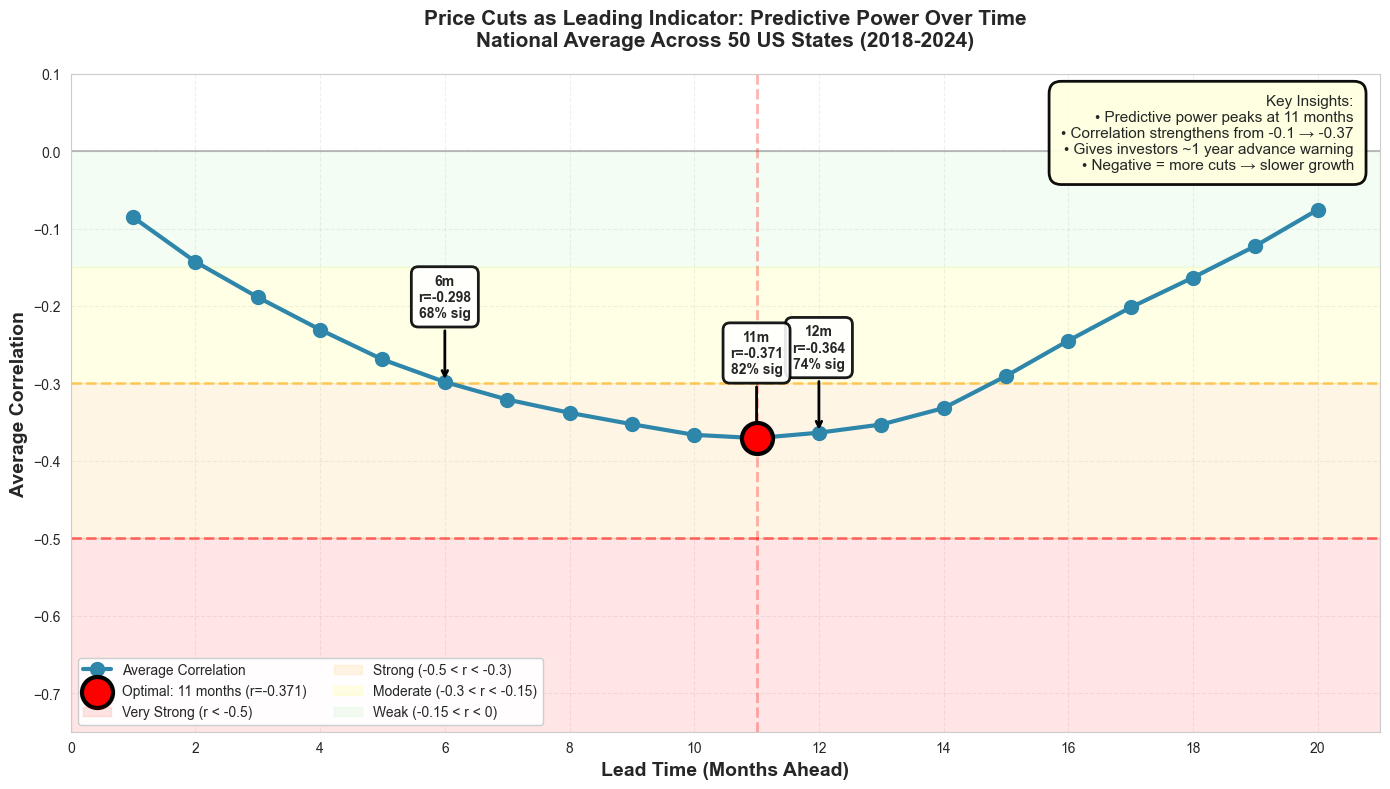

  ✓ Saved: viz1_national_pattern_20m.png

📊 Creating Visualization 2: Optimal Lag Distribution...


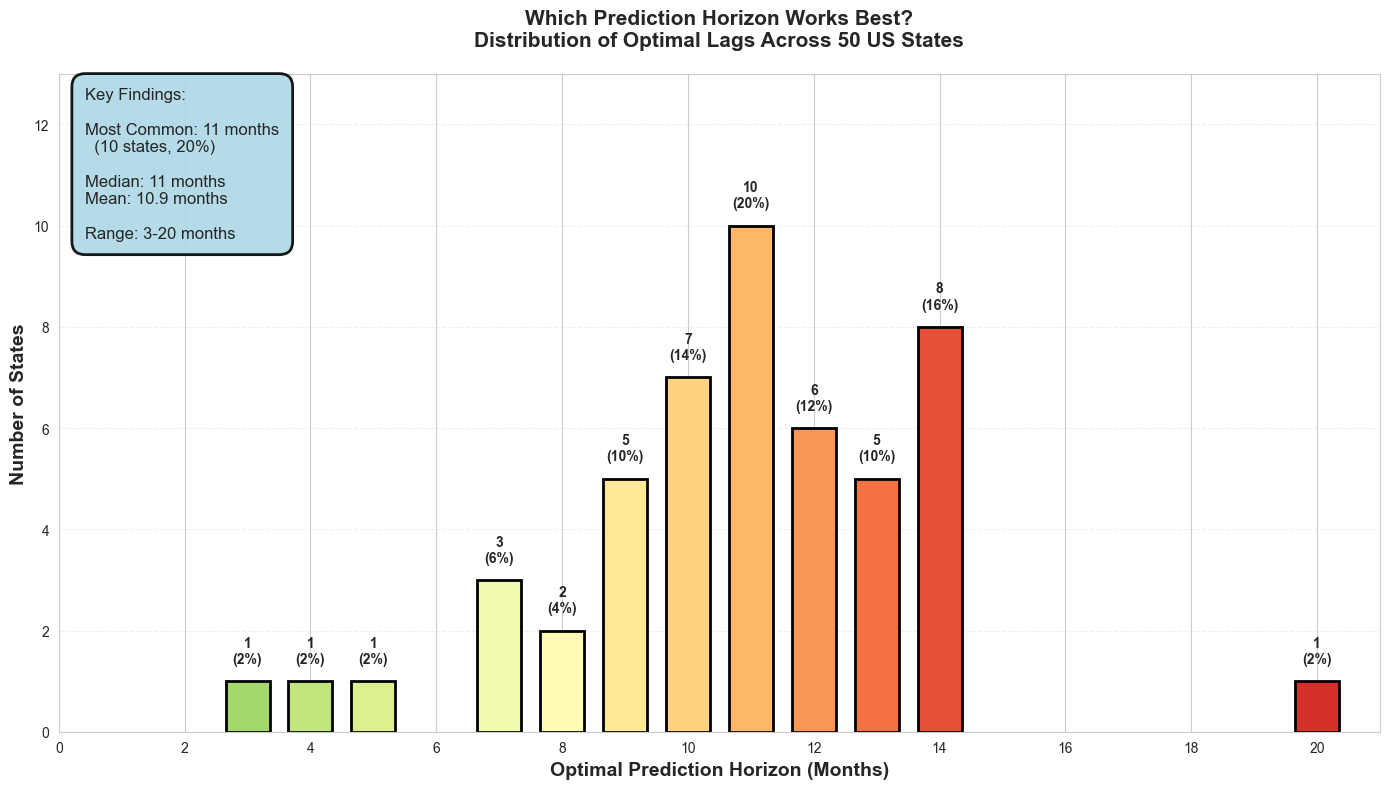

  ✓ Saved: viz2_lag_distribution_20m.png

📊 Creating Visualization 3: State Correlation Heatmap...


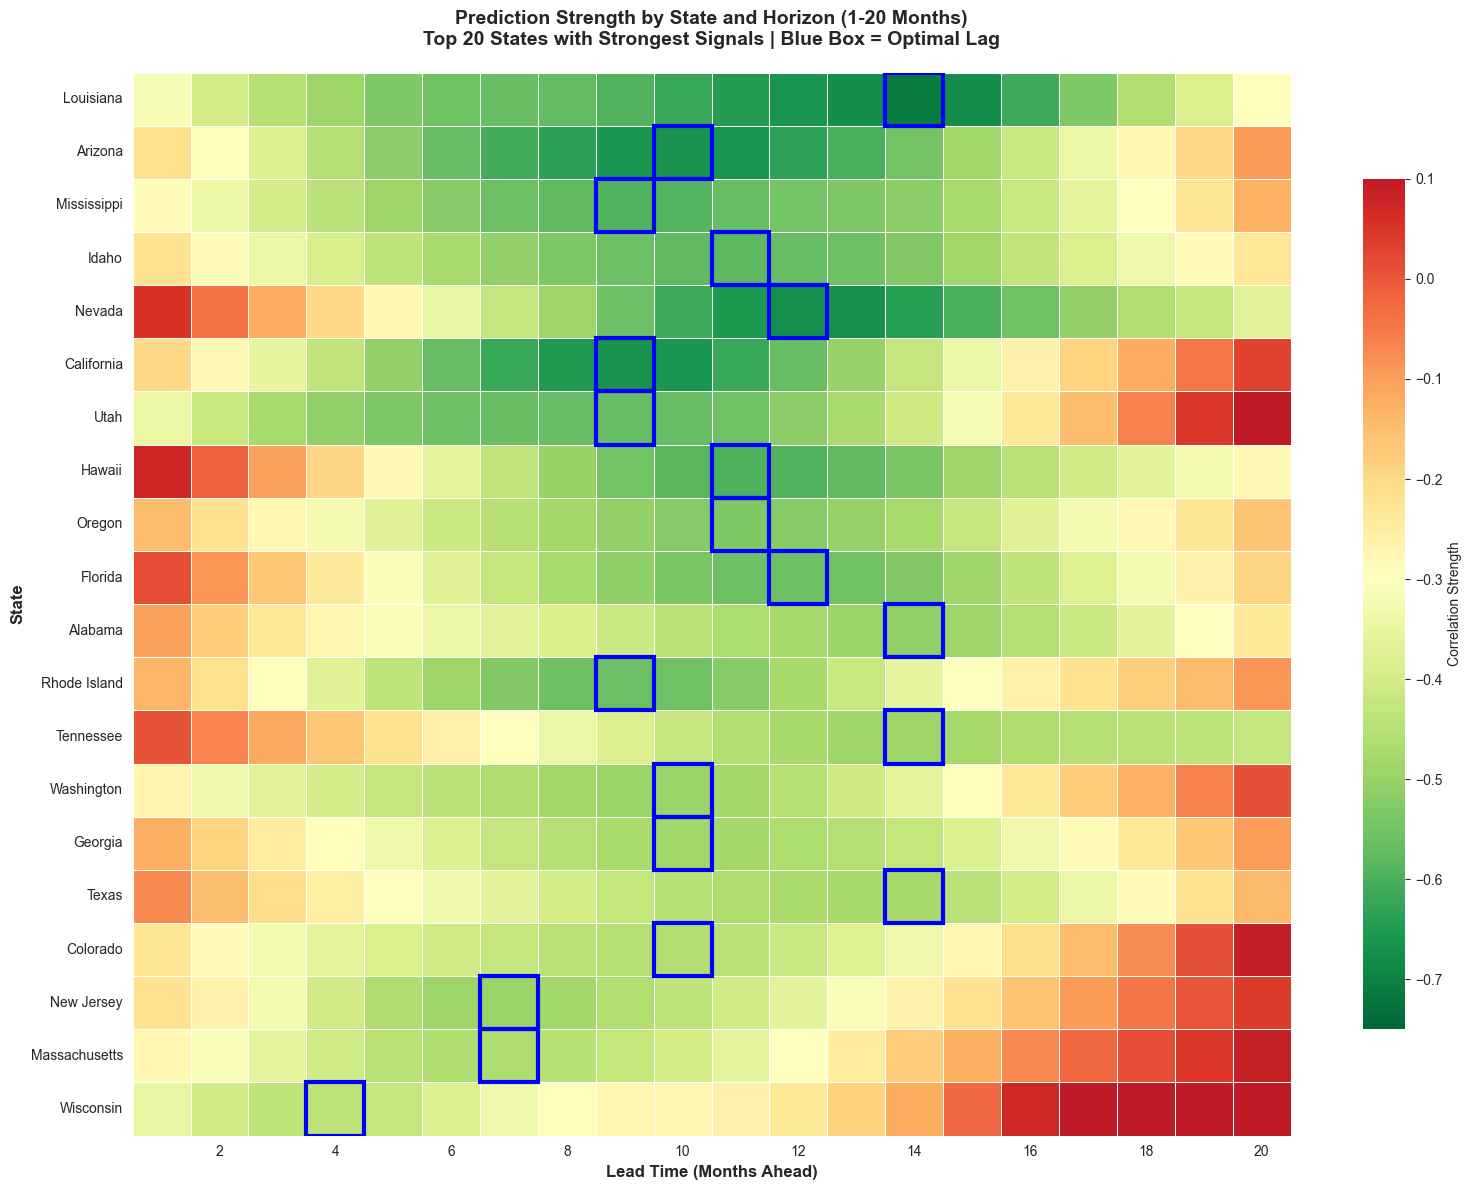

  ✓ Saved: viz3_state_heatmap_20m.png

📊 Creating Visualization 4: Lag vs Strength Scatter...


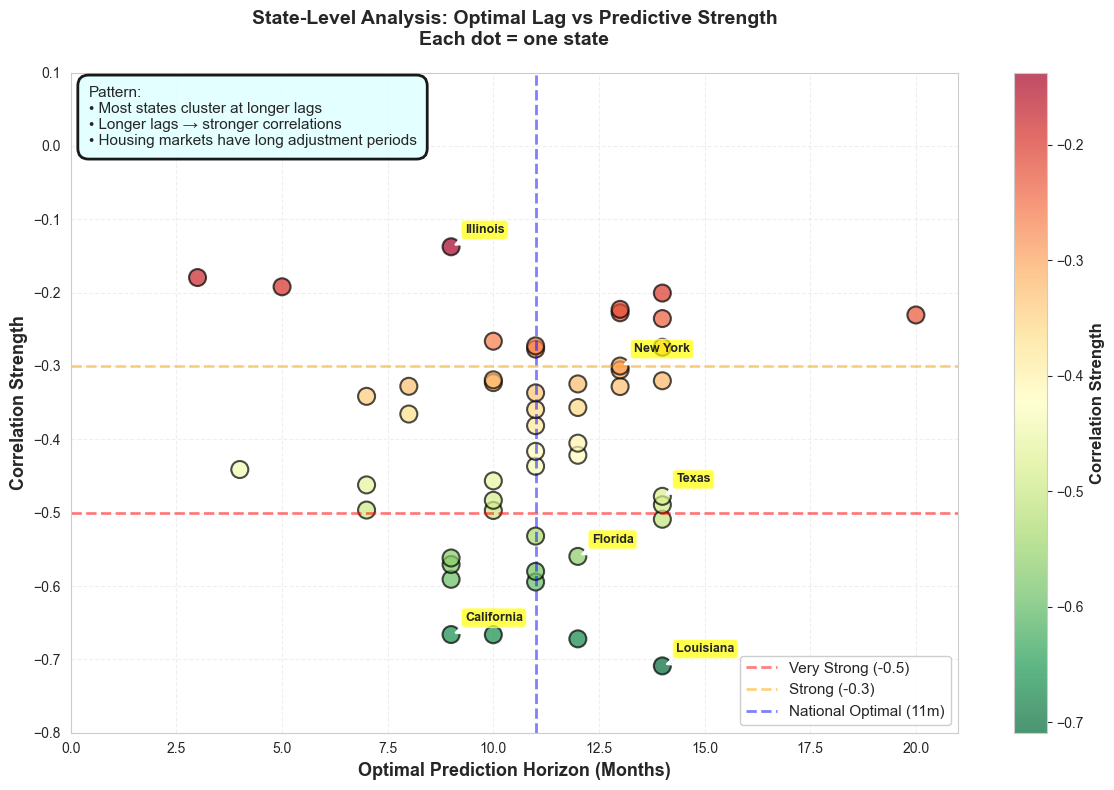

  ✓ Saved: viz4_lag_vs_strength_scatter.png

✅ STEP 4 COMPLETE - All visualizations created!

Created 4 visualizations:
  1. viz1_national_pattern_20m.png - Line chart (1-20 months)
  2. viz2_lag_distribution_20m.png - Bar chart of optimal lags
  3. viz3_state_heatmap_20m.png - Heatmap of top 20 states
  4. viz4_lag_vs_strength_scatter.png - Scatter plot lag vs strength


In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

print("=" * 70)
print("STEP 4: VISUALIZATION (1-20 MONTHS)")
print("=" * 70)

# Set style
sns.set_style("whitegrid")

# ============================================================================
# Load Results
# ============================================================================

print("\n📊 Loading results...")

input_dir = Path('../data/gold/zillow/q4')

national_avg = pd.read_csv(input_dir / 'lead_lag_national_average_20m.csv')
best_by_state = pd.read_csv(input_dir / 'lead_lag_best_by_state_20m.csv')

print(f"  National average: {national_avg.shape}")
print(f"  Best by state: {best_by_state.shape}")

# ============================================================================
# VISUALIZATION 1: National Average Correlation by Lag (1-20 Months)
# ============================================================================

print("\n📊 Creating Visualization 1: National Pattern (1-20 months)...")

fig, ax = plt.subplots(figsize=(14, 8))

# Plot line with markers
ax.plot(national_avg['Lead_Months'], national_avg['Correlation'], 
        marker='o', markersize=10, linewidth=3, color='#2E86AB', 
        label='Average Correlation', zorder=3)

# Highlight the optimal lag
optimal_idx = national_avg['Correlation'].idxmin()
optimal_lag = national_avg.loc[optimal_idx, 'Lead_Months']
optimal_corr = national_avg.loc[optimal_idx, 'Correlation']

ax.scatter(optimal_lag, optimal_corr, s=500, color='red', 
          zorder=5, edgecolor='black', linewidth=3, 
          label=f'Optimal: {int(optimal_lag)} months (r={optimal_corr:.3f})')

# Add shaded regions for interpretation
ax.axhspan(-1, -0.5, alpha=0.1, color='red', label='Very Strong (r < -0.5)')
ax.axhspan(-0.5, -0.3, alpha=0.1, color='orange', label='Strong (-0.5 < r < -0.3)')
ax.axhspan(-0.3, -0.15, alpha=0.1, color='yellow', label='Moderate (-0.3 < r < -0.15)')
ax.axhspan(-0.15, 0, alpha=0.1, color='lightgreen', label='Weak (-0.15 < r < 0)')

# Add reference lines
ax.axhline(y=0, color='gray', linestyle='-', linewidth=1.5, alpha=0.5)
ax.axhline(y=-0.5, color='red', linestyle='--', linewidth=2, alpha=0.5)
ax.axhline(y=-0.3, color='orange', linestyle='--', linewidth=2, alpha=0.5)

# Add vertical line at optimal
ax.axvline(x=optimal_lag, color='red', linestyle='--', linewidth=2, alpha=0.3)

# Annotate key milestones
key_lags = [6, 12, int(optimal_lag)]
for lag in key_lags:
    if lag in national_avg['Lead_Months'].values:
        corr_val = national_avg[national_avg['Lead_Months'] == lag]['Correlation'].values[0]
        sig_val = national_avg[national_avg['Lead_Months'] == lag]['Pct_Significant'].values[0]
        
        label_text = f"{lag}m\nr={corr_val:.3f}\n{sig_val:.0f}% sig"
        
        ax.annotate(label_text, 
                   xy=(lag, corr_val), 
                   xytext=(lag, corr_val + 0.08),
                   ha='center', va='bottom',
                   fontsize=10, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                            edgecolor='black', linewidth=2, alpha=0.9),
                   arrowprops=dict(arrowstyle='->', lw=2, color='black'))

# Styling
ax.set_xlabel('Lead Time (Months Ahead)', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Correlation', fontsize=14, fontweight='bold')
ax.set_title('Price Cuts as Leading Indicator: Predictive Power Over Time\nNational Average Across 50 US States (2018-2024)', 
            fontsize=15, fontweight='bold', pad=20)
ax.set_xlim(0, 21)
ax.set_ylim(-0.75, 0.1)
ax.set_xticks(range(0, 21, 2))
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=10, loc='lower left', framealpha=0.95, ncol=2)

# Add interpretation box
interpretation = (
    "Key Insights:\n"
    f"• Predictive power peaks at {int(optimal_lag)} months\n"
    f"• Correlation strengthens from -0.1 → {optimal_corr:.2f}\n"
    f"• Gives investors ~1 year advance warning\n"
    "• Negative = more cuts → slower growth"
)
ax.text(0.98, 0.97, interpretation, transform=ax.transAxes,
       fontsize=11, verticalalignment='top', horizontalalignment='right',
       bbox=dict(boxstyle='round,pad=0.8', facecolor='lightyellow', 
                edgecolor='black', linewidth=2, alpha=0.95))

plt.tight_layout()
plt.savefig(input_dir / 'viz1_national_pattern_20m.png', dpi=300, bbox_inches='tight')
plt.show()

print("  ✓ Saved: viz1_national_pattern_20m.png")

# ============================================================================
# VISUALIZATION 2: Distribution of Optimal Lags (Bar Chart)
# ============================================================================

print("\n📊 Creating Visualization 2: Optimal Lag Distribution...")

fig, ax = plt.subplots(figsize=(14, 8))

# Count states by optimal lag
lag_counts = best_by_state['Lead_Months'].value_counts().sort_index()

# Create color gradient based on lag value
colors_map = plt.cm.RdYlGn_r(np.linspace(0.3, 0.9, len(lag_counts)))

# Create bar chart
bars = ax.bar(lag_counts.index, lag_counts.values, 
             color=colors_map, edgecolor='black', linewidth=2, width=0.7)

# Add value labels on bars
for i, (lag, count) in enumerate(lag_counts.items()):
    pct = count / len(best_by_state) * 100
    if count > 0:
        ax.text(lag, count + 0.3,
               f'{int(count)}\n({pct:.0f}%)',
               ha='center', va='bottom', fontsize=10, fontweight='bold')

# Styling
ax.set_xlabel('Optimal Prediction Horizon (Months)', fontsize=14, fontweight='bold')
ax.set_ylabel('Number of States', fontsize=14, fontweight='bold')
ax.set_title('Which Prediction Horizon Works Best?\nDistribution of Optimal Lags Across 50 US States', 
            fontsize=15, fontweight='bold', pad=20)
ax.set_xlim(0, 21)
ax.set_xticks(range(0, 21, 2))
ax.set_ylim(0, max(lag_counts.values) * 1.3)
ax.grid(axis='y', alpha=0.3, linestyle='--')

# Add key finding box
most_common = int(lag_counts.idxmax())
most_common_count = int(lag_counts.max())
most_common_pct = most_common_count / len(best_by_state) * 100

# Calculate median optimal lag
median_lag = int(best_by_state['Lead_Months'].median())
mean_lag = best_by_state['Lead_Months'].mean()

finding = (
    f"Key Findings:\n\n"
    f"Most Common: {most_common} months\n"
    f"  ({most_common_count} states, {most_common_pct:.0f}%)\n\n"
    f"Median: {median_lag} months\n"
    f"Mean: {mean_lag:.1f} months\n\n"
    f"Range: {int(lag_counts.index.min())}-{int(lag_counts.index.max())} months"
)
ax.text(0.02, 0.98, finding, transform=ax.transAxes,
       fontsize=12, verticalalignment='top', horizontalalignment='left',
       bbox=dict(boxstyle='round,pad=0.8', facecolor='lightblue', 
                edgecolor='black', linewidth=2, alpha=0.9))

plt.tight_layout()
plt.savefig(input_dir / 'viz2_lag_distribution_20m.png', dpi=300, bbox_inches='tight')
plt.show()

print("  ✓ Saved: viz2_lag_distribution_20m.png")

# ============================================================================
# VISUALIZATION 3: Top 20 States Heatmap
# ============================================================================

print("\n📊 Creating Visualization 3: State Correlation Heatmap...")

# Get top 20 states by correlation strength
top_states = best_by_state.head(20)['State'].tolist()

# Load detailed results
detailed = pd.read_csv(input_dir / 'lead_lag_correlations_detailed_20m.csv')
detailed_top = detailed[detailed['State'].isin(top_states)]

# Pivot to create heatmap data
heatmap_data = detailed_top.pivot(index='State', columns='Lead_Months', values='Correlation')

# Sort by strongest average correlation
heatmap_data['Mean'] = heatmap_data.mean(axis=1)
heatmap_data = heatmap_data.sort_values('Mean')
heatmap_data = heatmap_data.drop(columns=['Mean'])

# Create heatmap
fig, ax = plt.subplots(figsize=(16, 12))

sns.heatmap(heatmap_data, 
            cmap='RdYlGn_r',  # Reversed so red = strong negative
            center=-0.3,
            vmin=-0.75, vmax=0.1,
            annot=False,  # Too crowded with 20 columns
            linewidths=0.5, linecolor='white',
            cbar_kws={'label': 'Correlation Strength', 'shrink': 0.8},
            ax=ax)

# Highlight optimal lags for each state
for i, state in enumerate(heatmap_data.index):
    optimal_lag_state = best_by_state[best_by_state['State'] == state]['Lead_Months'].values[0]
    if optimal_lag_state in heatmap_data.columns:
        col_idx = list(heatmap_data.columns).index(optimal_lag_state)
        # Draw a box around the optimal cell
        ax.add_patch(plt.Rectangle((col_idx, i), 1, 1, 
                                   fill=False, edgecolor='blue', lw=3))

ax.set_title('Prediction Strength by State and Horizon (1-20 Months)\nTop 20 States with Strongest Signals | Blue Box = Optimal Lag', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Lead Time (Months Ahead)', fontsize=12, fontweight='bold')
ax.set_ylabel('State', fontsize=12, fontweight='bold')

# Only show every 2nd x-tick label for readability
xtick_labels = [str(i) if i % 2 == 0 else '' for i in range(1, 21)]
ax.set_xticklabels(xtick_labels)

plt.tight_layout()
plt.savefig(input_dir / 'viz3_state_heatmap_20m.png', dpi=300, bbox_inches='tight')
plt.show()

print("  ✓ Saved: viz3_state_heatmap_20m.png")

# ============================================================================
# VISUALIZATION 4: Scatter Plot - Optimal Lag vs Correlation Strength
# ============================================================================

print("\n📊 Creating Visualization 4: Lag vs Strength Scatter...")

fig, ax = plt.subplots(figsize=(12, 8))

# Create scatter plot
scatter = ax.scatter(best_by_state['Lead_Months'], 
                    best_by_state['Correlation'],
                    s=150,
                    c=best_by_state['Correlation'],
                    cmap='RdYlGn_r',
                    alpha=0.7,
                    edgecolor='black',
                    linewidth=1.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Correlation Strength', fontsize=12, fontweight='bold')

# Annotate a few interesting states
interesting_states = ['California', 'Texas', 'Florida', 'New York', 
                     best_by_state.iloc[0]['State'],  # Strongest correlation
                     best_by_state.iloc[-1]['State']]  # Weakest correlation

for state in interesting_states:
    if state in best_by_state['State'].values:
        row = best_by_state[best_by_state['State'] == state].iloc[0]
        ax.annotate(state, 
                   xy=(row['Lead_Months'], row['Correlation']),
                   xytext=(10, 10), textcoords='offset points',
                   fontsize=9, fontweight='bold',
                   bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7),
                   arrowprops=dict(arrowstyle='->', lw=1.5))

# Add reference lines
ax.axhline(y=-0.5, color='red', linestyle='--', linewidth=2, alpha=0.5, 
          label='Very Strong (-0.5)')
ax.axhline(y=-0.3, color='orange', linestyle='--', linewidth=2, alpha=0.5,
          label='Strong (-0.3)')
ax.axvline(x=optimal_lag, color='blue', linestyle='--', linewidth=2, alpha=0.5,
          label=f'National Optimal ({int(optimal_lag)}m)')

# Styling
ax.set_xlabel('Optimal Prediction Horizon (Months)', fontsize=13, fontweight='bold')
ax.set_ylabel('Correlation Strength', fontsize=13, fontweight='bold')
ax.set_title('State-Level Analysis: Optimal Lag vs Predictive Strength\nEach dot = one state', 
            fontsize=14, fontweight='bold', pad=20)
ax.set_xlim(0, 21)
ax.set_ylim(-0.8, 0.1)
ax.grid(True, alpha=0.3, linestyle='--')
ax.legend(fontsize=11, loc='lower right', framealpha=0.95)

# Add interpretation
interpretation = (
    "Pattern:\n"
    "• Most states cluster at longer lags\n"
    "• Longer lags → stronger correlations\n"
    "• Housing markets have long adjustment periods"
)
ax.text(0.02, 0.98, interpretation, transform=ax.transAxes,
       fontsize=11, verticalalignment='top', horizontalalignment='left',
       bbox=dict(boxstyle='round,pad=0.7', facecolor='lightcyan', 
                edgecolor='black', linewidth=2, alpha=0.9))

plt.tight_layout()
plt.savefig(input_dir / 'viz4_lag_vs_strength_scatter.png', dpi=300, bbox_inches='tight')
plt.show()

print("  ✓ Saved: viz4_lag_vs_strength_scatter.png")

print("\n" + "=" * 70)
print("✅ STEP 4 COMPLETE - All visualizations created!")
print("=" * 70)
print("\nCreated 4 visualizations:")
print("  1. viz1_national_pattern_20m.png - Line chart (1-20 months)")
print("  2. viz2_lag_distribution_20m.png - Bar chart of optimal lags")
print("  3. viz3_state_heatmap_20m.png - Heatmap of top 20 states")
print("  4. viz4_lag_vs_strength_scatter.png - Scatter plot lag vs strength")